In [9]:
pip install dwave-ocean-sdk

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler, EmbeddingComposite
token = "Тут был мой токен"

In [20]:
def J_gen(L,j1,j2):
    J = np.zeros((L*L, L*L))
    for i in range(L):
        for j in range(L):
            J[i * L + j, i * L + ((j + 1) % L)] = j1
            J[i * L + j, ((i + 1) % L) * L + j] = j1
            J[i * L + j, ((i + 1) % L) * L + ((j + 1) % L)] = j2
            J[i * L + j, ((i + 1) % L) * L + ((j - 1) % L)] = j2
    J = 0.5 * (J + J.T)
    return J

def Q_gen(L,j1,j2):
  J = -1 * J_gen(L,j1,j2)
  Q = np.zeros(L ** 2)
  for p in range(L ** 2):
    Q[p] = - 2 * (sum(J[:, p]) + sum(J[p, :]))
  Q = 4 * J + np.diag(Q)
  shift = sum(sum(J))
  return Q, shift

def get_data_DWAVE(L, Kappa, N, M, token = token):
  sampler = EmbeddingComposite(DWaveSampler(token=token))
  energy_points = []
  polarization_points = []
  for i in range(N):
    j1 = 1
    j2 = -1 * Kappa * (i / N)
    Q, shift = Q_gen(L,j1,j2)
    b = []
    c = []
    for j in range(M):
      sample = sampler.sample_qubo(Q)
      energy = float(sample.record['energy']) + shift
      polarization = abs(sum(sum(sample.record['sample']))/(L * L) - 0.5)
      b.append(energy)
      c.append(polarization)
    energy_points.append(np.sort(b))
    polarization_points.append(c[np.argmin(b)])
  energy_points = (1/ L * L) * np.array(energy_points).T
  return energy_points, polarization_points

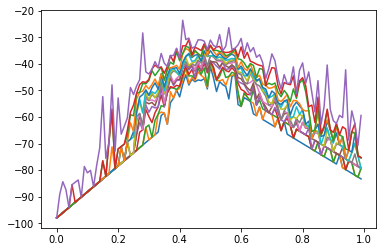

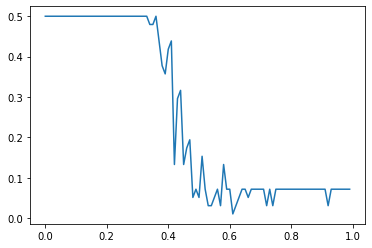

In [21]:
N = 100
M = 15
a, b = get_data_DWAVE(L = 7, Kappa = 1, N = N, M = M)
np.save('dwave-data_energy', a)
np.save('dwave-data_polarization', b)
for x in a:
    plt.plot( (1 / (N)) * np.array(range(N)), x)
plt.show()
plt.plot( (1 / (N)) * np.array(range(N)), b)


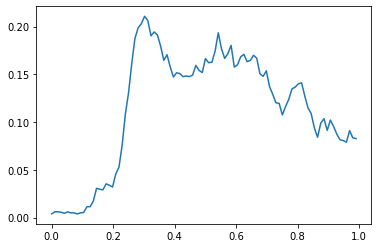

In [25]:
N = 100
K = 5
s = np.zeros(N)
for x in a:
  s += x - a[0]
s = (1/M) * s / abs(a[0])
plt.plot( (1 / (N - K + 1)) * np.array(range(N - K + 1)), np.convolve(s, np.ones(K)/K, mode='valid'))